<a href="https://colab.research.google.com/github/daviddralle/salmonid_and_subsurface/blob/main/lpi_analysis_salmonid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install, import, download data

In [ ]:
!pip install -q daymetpy

import sys
import daymetpy
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import misc 
import glob as glob
import numpy as np
from scipy.stats import binned_statistic
import matplotlib
import os, pkg_resources
# get LPI data
import requests
def download_file(url):
  fn = url.split('/')[-1]
  r = requests.get(url, allow_redirects=True)
  open(fn, 'wb').write(r.content)
download_file('https://github.com/daviddralle/salmonid_and_subsurface/raw/main/data_files.zip')
import zipfile
with zipfile.ZipFile('./data_files.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
master = pd.read_csv('./lpi_pts.csv',index_col=0)

brans = (-123.622134, 39.662731)
brans = daymetpy.daymet_timeseries(lon=brans[0], lat=brans[1], start_year=2001, end_year=2020)
brans['month'] = brans.index.month
annual = brans.groupby('month').mean()[['srad', 'dayl']]
annual['total'] = annual.srad * annual.dayl / 1e6
summer_daily_mean = annual.loc[annual.index.isin([6,7,8])].total.mean()

# Binning function (after Kirchner 2009)

In [ ]:
def binning(df, min_per_bin):
  df = df.sort_values('area',ascending=True)
  logA = np.array(np.log(df.area))
  logRange = np.max(logA) - np.min(logA)
  minBinSize = logRange*.01
  binBoundaries = [0]
  for i in range(1,len(df)):    
    if abs(logA[i] - logA[binBoundaries[-1]]) < minBinSize: 
      continue  
    if abs(i-binBoundaries[-1]) < min_per_bin:
      continue
    curr = df.lpi[binBoundaries[-1]:i]
    if np.std(curr)/np.sqrt(abs(i-binBoundaries[-1])) > np.mean(curr)/2: 
      continue    
    binBoundaries.append(i)
  return binBoundaries

# Incident shortwave = f(contributing area, geology)

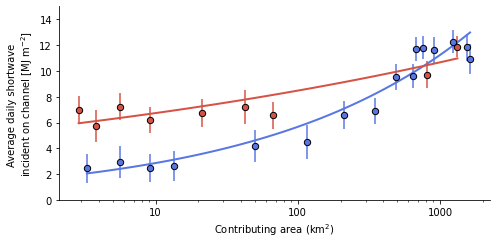

In [ ]:
cmap = matplotlib.cm.get_cmap('coolwarm')

df = master.loc[(master.lpi<1)&(master.lpi>0.001)]
df = df.loc[df['area']<2*10**9]
f, ax = plt.subplots(figsize=(7,3.5))
cmap = matplotlib.cm.get_cmap('coolwarm')

# Plot coastal belt light
c = cmap(0.1)
temp = df.loc[df.geo==1].sort_values('area')
binBoundaries = binning(temp,min_per_bin=300)
x = np.array(temp['area'].values)/1e6
y = np.array(temp['lpi'].values)
xs = np.array([np.mean(x[binBoundaries[i]:binBoundaries[i+1]]) for i in range(len(binBoundaries)-1)])
ys = np.array([np.mean(y[binBoundaries[i]:binBoundaries[i+1]]) for i in range(len(binBoundaries)-1)])
sigmas = np.array([np.std(np.log(y[binBoundaries[i]:binBoundaries[i+1]]))/np.sqrt(binBoundaries[i+1]-binBoundaries[i]) for i in range(len(binBoundaries)-1)]) + 1e-12
sds = np.array([np.std(np.log(y[binBoundaries[i]:binBoundaries[i+1]])) for i in range(len(binBoundaries)-1)]) + 1e-12
ax.scatter(xs,summer_daily_mean*ys,ec='k',s=40,color=c, label='Coastal',zorder=9)
ax.errorbar(xs,summer_daily_mean*ys,yerr=sds,color=c,ls='none')
p = np.polyfit(x=np.log(xs), y=np.log(ys), deg=1, w=1/sigmas**2)
xsfit = np.logspace(np.log10(np.min(xs)), np.log10(np.max(xs)))
if len(p)>2:
  ysfit = np.exp(p[2] + p[1]*np.log(xsfit) + p[0]*np.log(xsfit)**2)
else:
  ysfit = np.exp(p[1] + p[0]*np.log(xsfit))
rad = ysfit*summer_daily_mean
ax.plot(xsfit, rad,lw=2,c=c)

# Plot melange geology
c = cmap(0.9)
temp = df.loc[df.geo==2].sort_values('area')
binBoundaries = binning(temp,min_per_bin=300)
x = np.array(temp['area'].values)/1e6
y = np.array(temp['lpi'].values)
xs = np.array([np.mean(x[binBoundaries[i]:binBoundaries[i+1]]) for i in range(len(binBoundaries)-1)])
ys = np.array([np.mean(y[binBoundaries[i]:binBoundaries[i+1]]) for i in range(len(binBoundaries)-1)])
sigmas = np.array([np.std(np.log(y[binBoundaries[i]:binBoundaries[i+1]]))/np.sqrt(binBoundaries[i+1]-binBoundaries[i]) for i in range(len(binBoundaries)-1)]) + 1e-12
sds = np.array([np.std(np.log(y[binBoundaries[i]:binBoundaries[i+1]])) for i in range(len(binBoundaries)-1)]) + 1e-12
ax.scatter(xs,summer_daily_mean*ys,ec='k',s=40,color=c, label='Melange',zorder=20)
ax.errorbar(xs,summer_daily_mean*ys,yerr=sds,color=c,ls='none')
p = np.polyfit(x=np.log(xs), y=np.log(ys), deg=1, w=1/sigmas**2)
xsfit = np.logspace(np.log10(np.min(xs)), np.log10(np.max(xs)))
if len(p)>2:
  ysfit = np.exp(p[2] + p[1]*np.log(xsfit) + p[0]*np.log(xsfit)**2)
else:
  ysfit = np.exp(p[1] + p[0]*np.log(xsfit))
rad = ysfit*summer_daily_mean
ax.plot(xsfit, rad,lw=2,c=c)

ax.set_xscale('log')
ax.set_ylabel('Average daily shortwave \nincident' + r' on channel [MJ m$^{-2}$]')
ax.set_ylim([0,15])
ax.set_xlabel(r'Contributing area (km$^2$)')
ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.0f"))
sns.despine(right=True, top=True)
f.tight_layout()
f.savefig('./lpi.pdf')